## Exploratory Data Analysis (EDA): Rent Growth & Vacancy

This notebook explores the historical rental market behavior to inform scenario assumptions (Bear/Base/Bull) used in the residential investment financial model. 

The objective is to: 
- Understand the distribution of rent growth 
- Identify downside and upside risk 
- Calibrate scenario assumptions using empirical data 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [40]:
path = "../data/raw/abs_cpi_rents.csv"
raw = pd.read_csv(path, skiprows=1) #header row is not needed 
raw.head(20)

,Unnamed: 0,Annual (RHS) (%),Monthly (LHS) (%)
0,Sep-22,2.9,0.5
1,Oct-22,3.5,0.6
2,Nov-22,3.6,0.2
3,Dec-22,4.1,0.5
4,Jan-23,4.8,0.7
5,Feb-23,4.8,0.7
6,Mar-23,5.3,0.5
7,Apr-23,6.1,0.8
8,May-23,6.3,0.8
9,Jun-23,7.3,0.9


In [41]:
raw.columns

Index(['Unnamed: 0', 'Annual (RHS) (%)', 'Monthly (LHS) (%)'], dtype='object')

## Data Description 

Expected structure: 
- Date: Monthly or quarterly timestamp 
- Rate Index or Rent: level series 
- Vacancy Rate: percentage

Transformation: 
- Convert level series to year-on-year (YoY) growth 
- Cleaning of raw data, aligning frequency and handling any missing values 

In [42]:
#Standardising the dataframe to two columns (date and rent_growth_yoy)

# Standardise the dataframe to two columns (date and rent_growth_yoy)
df = raw.rename(columns={raw.columns[0]: "Date","Annual (RHS) (%)": "rent_growth_yoy"})[["Date", "rent_growth_yoy"]].copy()

df["Date"] = pd.to_datetime(df["Date"], format="%b-%y", errors="coerce")

df["rent_growth_yoy"] = pd.to_numeric(df["rent_growth_yoy"], errors="coerce") / 100.0 #convert % to decimal

df = df.dropna(subset=["Date", "rent_growth_yoy"]).sort_values("Date").reset_index(drop=True)

df.head(10)

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048
5,2023-02-01,0.048
6,2023-03-01,0.053
7,2023-04-01,0.061
8,2023-05-01,0.063
9,2023-06-01,0.073


## Exploratory Analysis Plan 

1. Visualise distribution of rent growth 
2. Identify downside and upside tails 
3. Compute summary statistics: 
    - Mean 
    - Median 
    - Standard Deviation 
    - 10th / 50th / 90th percentiles 
4. Map percentiles to Bear / Base / Bull assumptions 

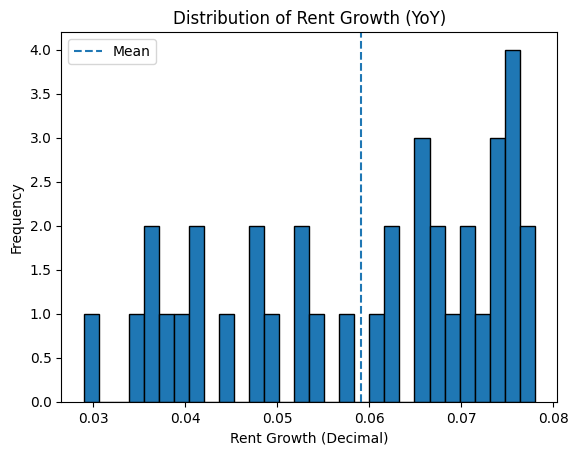

In [37]:
#Plotting histogram 
plt.figure()
plt.hist(df["rent_growth_yoy"], bins=30, edgecolor="black")
plt.axvline(df["rent_growth_yoy"].mean(), linestyle="--",label="Mean")
plt.title("Distribution of Rent Growth (YoY)")
plt.xlabel("Rent Growth (Decimal)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [40]:
#Summary Statistics & Percentiles 

p10, p50,p90 = np.percentile(df["rent_growth_yoy"],[10,50,90])

summary = pd.DataFrame({
    "Statistics": ["Mean","Base (50th Percentile)","Bear (10th Percentile)","Bull (90th Percentile)", "Std Dev"],
    "Rent Growth": [
        df["rent_growth_yoy"].mean(),
        p50,
        p10,
        p90,
        df["rent_growth_yoy"].std()
    ]
})

summary

,Statistics,Rent Growth
0,Mean,0.059162
1,Base (50th Percentile),0.063000
2,Bear (10th Percentile),0.037600
3,Bull (90th Percentile),0.076000
4,Std Dev,0.014861


## Scenario Calibration 

Based on historical distribution of YoY rent growth: 
- Bear case = 0.0376 (10th percentile)
- Base case = 0.0630 (50th percentile/median)
- Bull case = 0.0760 (90th percentile)

These values are used directly in the rent growth assumption in the financial model. 

In [44]:
summary.to_csv("../outputs/rent_growth_percentiles.csv",index=False)

## Vacancy Rate Analysis 

This section analyses historical vacancy rate behavior to understand operating risk and volatility affecting net operating income (NOI).

SQM vacancy data is only available as a snapshot from May 2024 - May 2025. To analyse vacancy volatility, tail risk, and run Monte Carlo on NOI, I built a synthetic monthly vacancy rate time series, with the goal of: 

- Calibrating level to SQM national vacancy rates
- Including volatility and tail events to represent downturn risk
- Keeping series bounded: vacancy rates cannot be negative and typically remain in a sensible range 

### Assumptions: 

This project calibrates the synthetic series to the base vacancy rate (1.30%) and add: 
- Normal month-to-month variation (volatility) 
- Occasional shock months (recession like vacancy spikes)

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

VAC_BASE = 0.013
VAC_BEAR = 0.018
VAC_BULL = 0.010

MONTHLY_VOL = 0.0015 #about 0.15% monthly std dev
MEAN_REVERT_SPEED = 0.35 #how strongly vacancy reverts to base each month 

#Tail events/shock months 
SHOCK_PROB = 0.4 #about 4% chance a month is shock month 
SHOCK_MEAN = 0.010 #an average shock will add 1% vacancy
SHOCK_STD = 0.005 #shock variability 

VAC_MIN = 0.0 #cannot be negative
VAC_MAX = 0.10

## Monthly Date Index 
Since cash flow model runs 5 years monthly, a 5-year monthly series is built 

In [4]:
start_date = "2025-07-01"
months = 60

dates = pd.date_range(start=start_date,periods=months,freq="MS") #month start


## Simulating vacancy using mean reversion and shocks (for stress testing NOI)

Vacancy is modelled as: 
- reverting towards the base level over time 
- disturbed by random monthly noise 
- occasionally hit by shock events 

In [11]:
rng = np.random.default_rng(42)
vac = np.zeros(len(dates))
vac[0] = VAC_BASE

for t in range(1, len(dates)):
    revert = MEAN_REVERT_SPEED * (VAC_BASE - vac[t-1]) #mean reversion
    noise = rng.normal(0, MONTHLY_VOL) #nomal month-to-month noise
    is_shock = rng.uniform() < SHOCK_PROB #shock component (tail risk)
    shock = rng.normal(SHOCK_MEAN, SHOCK_STD) if is_shock else 0.0
    
    vac[t] = vac[t-1] + revert + noise + shock


vac = np.clip(vac,VAC_MIN,VAC_MAX)

vacancy_df = pd.DataFrame({"Date": dates, "vacancy_rate": vac})
vacancy_df.head()

,Date,vacancy_rate
0,2025-07-01,0.013000
1,2025-08-01,0.013457
2,2025-09-01,0.014423
3,2025-10-01,0.010998
4,2025-11-01,0.011891


In [10]:
summary = vacancy_df["vacancy_rate"].describe(percentiles=[0.01, 0.05, 0.95, 0.99])
summary

count    60.000000
mean      0.022264
std       0.007324
min       0.010998
1%        0.011525
5%        0.012963
50%       0.022239
95%       0.034476
99%       0.037653
max       0.039664
Name: vacancy_rate, dtype: float64

## Synthetic Vacancy Time Series Plots 

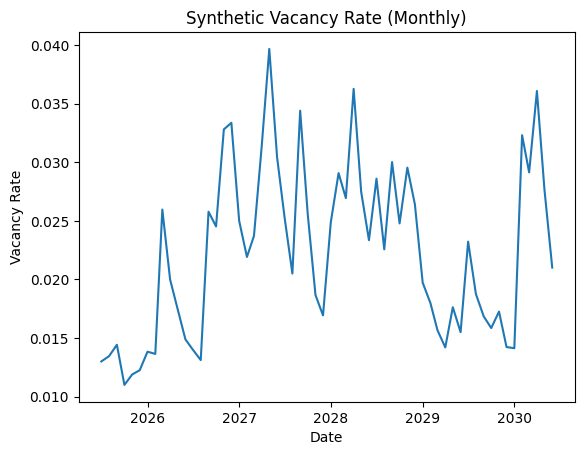

In [13]:
plt.figure()
plt.plot(vacancy_df["Date"],vacancy_df["vacancy_rate"])
plt.title("Synthetic Vacancy Rate (Monthly)")
plt.xlabel("Date")
plt.ylabel("Vacancy Rate")
plt.show()

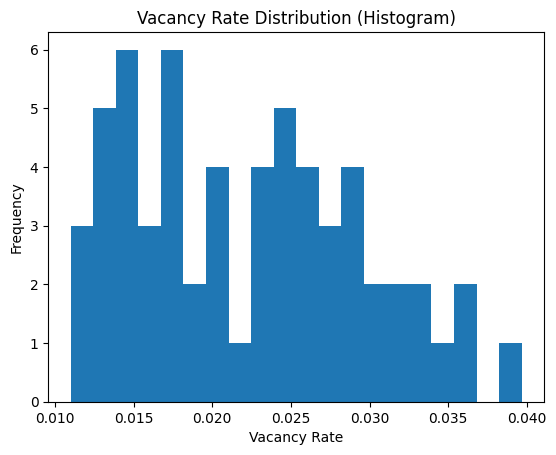

In [14]:
plt.figure()
plt.hist(vacancy_df["vacancy_rate"], bins=20)
plt.title("Vacancy Rate Distribution (Histogram)")
plt.xlabel("Vacancy Rate")
plt.ylabel("Frequency")
plt.show()

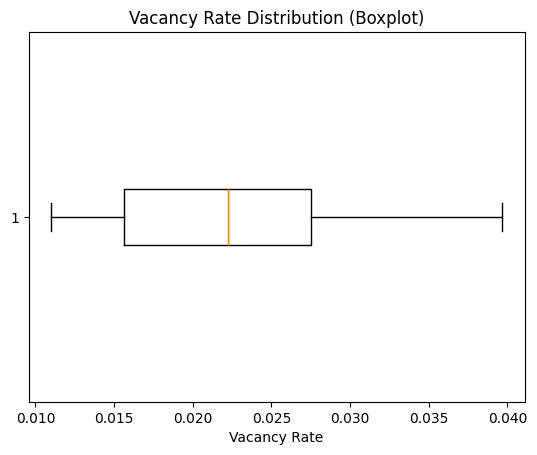

In [15]:
plt.figure()
plt.boxplot(vacancy_df["vacancy_rate"],vert=False)
plt.title("Vacancy Rate Distribution (Boxplot)")
plt.xlabel("Vacancy Rate")
plt.show()

In [20]:
from pathlib import Path

Path("data/processed").mkdir(parents=True, exist_ok=True)
out_path = "data/processed/vacancy_synthetic_monthly.csv"
vacancy_df.to_csv(out_path, index=False)

out_path

'data/processed/vacancy_synthetic_monthly.csv'

## Tail Risk Analysis 

This section focuses on downside risk by examining the lower tail of historical rent growth outcomes. The objective is to understand how severe negative or low-growth periods can be relative to typical conditions. 

In [46]:
p10 = np.percentile(df["rent_growth_yoy"],10)

tail_df = df[df["rent_growth_yoy"] <= 10]
tail_df.head()

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048


In [48]:
#Comparing downside vs central tendency 
comparison = pd.DataFrame({
    "Metric": ["Mean","Median","10th Percentile"],
    "Rent Growth": [
        df["rent_growth_yoy"].mean(),
        df["rent_growth_yoy"].median(),
        p10
    ]
})

comparison

,Metric,Rent Growth
0,Mean,0.059162
1,Median,0.063000
2,10th Percentile,0.037600


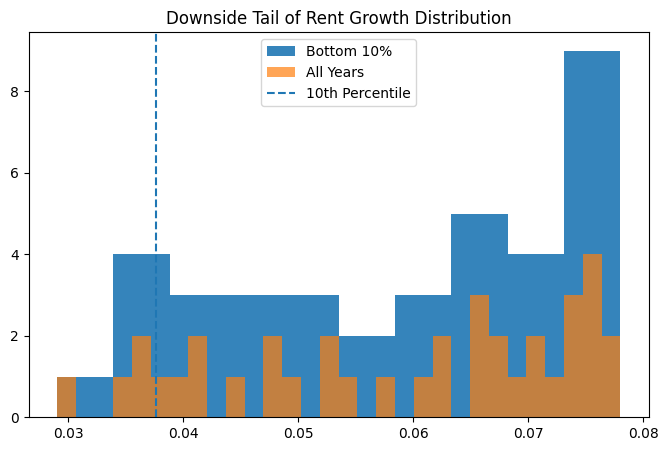

In [52]:
plt.figure(figsize=(8, 5))
plt.hist(tail_df["rent_growth_yoy"], bins=10, alpha=0.9, label="Bottom 10%")
plt.hist(df["rent_growth_yoy"], bins=30, alpha=0.7, label="All Years")
plt.axvline(p10, linestyle="--", label="10th Percentile")
plt.title("Downside Tail of Rent Growth Distribution")
plt.legend()
plt.show()

Tail Risk Metrics for Vacancy 

In [16]:
p5 = vacancy_df["vacancy_rate"].quantile(0.05)
p1 = vacancy_df["vacancy_rate"].quantile(0.1)

worst = vacancy_df.sort_values("vacancy_rate", ascending=False).head(3)

p5,p1,worst

(np.float64(0.012962685197516085),
 np.float64(0.013622741653722762),
          Date  vacancy_rate
 22 2027-05-01      0.039664
 33 2028-04-01      0.036256
 57 2030-04-01      0.036076)

# Correlation Analysis: Rent Growth vs Interest Rates 

This section aims to examine the relationship between rental growth and interest rates. 

Understanding this relationship is significant for 
- Stress testing rental income assumptions 
- Assessing macro-driven downside risks 
- Evaluating whether or not rising interest rates suppress or lag rental growth 

The relationship will be visualised using a heatmap. 

In [31]:
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx")
rba_raw.head(20)


,F1 INTEREST RATES AND YIELDS – MONEY MARKET,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Title,Cash Rate Target,Change in the Cash Rate Target,Interbank Overnight Cash Rate,Highest Interbank Overnight Cash Rate,Lowest Interbank Overnight Cash Rate,Volume of Cash Market Transactions,Number of Cash Market Transactions,Total Return Index,EOD 1-month BABs/NCDs,EOD 3-month BABs/NCDs,EOD 6-month BABs/NCDs,1-month OIS,3-month OIS,6-month OIS,1-month Treasury Note,3- month Treasury Note,6- month Treasury Note
1,Description,Cash Rate Target on date,Change in the Cash Rate Target (in percentage ...,Interbank Overnight Cash Rate on date,Highest Interbank Overnight Cash Rate on date,Lowest Interbank Overnight Cash Rate on date,Volume of Interbank Overnight Cash Market Tran...,Number of Interbank Overnight Cash Market Tran...,Cash Rate Total Return Index on date,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Bank Accepted Bills/Negotiable Certificates of...,Overnight Indexed Swaps-1 month,Overnight Indexed Swaps-3 months,Overnight Indexed Swaps-6 months,Treasury Note-1 month,Treasury Note-3 month,Treasury Note-6 month
2,Frequency,Daily,as announced,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily,Daily
3,Type,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original,Original
4,Units,Per cent,Per cent,Per cent,Per cent,Per cent,$m,Number,Index 04-Jan-2011=100,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent,Per cent
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Source,RBA,RBA,RBA,RBA,RBA,RBA,RBA,RBA,ASX,ASX,ASX,FENICS,FENICS,FENICS,RBA,RBA,RBA
8,Publication date,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00,2026-01-09 00:00:00
9,Series ID,FIRMMCRTD,FIRMMCCRT,FIRMMCRID,FIRMMCRIH,FIRMMCRIL,FIRMMCRIV,FIRMMCRIN,FIRMMCTRI,FIRMMBAB30D,FIRMMBAB90D,FIRMMBAB180D,FIRMMOIS1D,FIRMMOIS3D,FIRMMOIS6D,FIRMMTN1D,FIRMMTN3D,FIRMMTN6D


In [37]:
#only first 2 columns are relevant
#remove first 10 rows
rba_raw = pd.read_excel("../data/raw/rba_cash_rate.xlsx", skiprows=10)
rba = rba_raw.iloc[:, [0, 1]].copy()
rba.columns = ["Date", "cash_rate"]

rba["Date"] = pd.to_datetime(rba["Date"], errors="coerce")
rba["cash_rate"] = pd.to_numeric(rba["cash_rate"], errors="coerce") / 100.0

rba = rba.dropna().sort_values("Date").reset_index(drop=True)
rba.head(20)


,Date,cash_rate
0,2011-01-04,0.0475
1,2011-01-05,0.0475
2,2011-01-06,0.0475
3,2011-01-07,0.0475
4,2011-01-10,0.0475
5,2011-01-11,0.0475
6,2011-01-12,0.0475
7,2011-01-13,0.0475
8,2011-01-14,0.0475
9,2011-01-17,0.0475


In [38]:
#since rba is currently daily, have to convert it to monthly 
rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())
rba_monthly.head(20)

C:\Users\trabi\AppData\Local\Temp\ipykernel_15876\820826536.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rba_monthly = (rba.set_index("Date").resample("M").mean().reset_index())


,Date,cash_rate
0,2011-01-31,0.047500
1,2011-02-28,0.047500
2,2011-03-31,0.047500
3,2011-04-30,0.047500
4,2011-05-31,0.047500
5,2011-06-30,0.047500
6,2011-07-31,0.047500
7,2011-08-31,0.047500
8,2011-09-30,0.047500
9,2011-10-31,0.047500


In [44]:
#Rent growth data from above
rent_df = df.copy()
rent_df.head()

,Date,rent_growth_yoy
0,2022-09-01,0.029
1,2022-10-01,0.035
2,2022-11-01,0.036
3,2022-12-01,0.041
4,2023-01-01,0.048


In [49]:
#since rent data is month start, shift rba monthly to start as well 
rba_monthly["Date"] = rba_monthly["Date"].dt.to_period("M").dt.to_timestamp(how="start")

In [50]:
#merging rent and interest rate dataframes
combined = pd.merge(rent_df,rba_monthly,on="Date",how="inner")
combined.head(10)

,Date,rent_growth_yoy,cash_rate
0,2022-09-01,0.029,0.022548
1,2022-10-01,0.035,0.025762
2,2022-11-01,0.036,0.028386
3,2022-12-01,0.041,0.030500
4,2023-01-01,0.048,0.031000
5,2023-02-01,0.048,0.032875
6,2023-03-01,0.053,0.035457
7,2023-04-01,0.061,0.036000
8,2023-05-01,0.063,0.038283
9,2023-06-01,0.073,0.040524


In [51]:
#correlation analysis 
combined[["rent_growth_yoy","cash_rate"]].corr()

,rent_growth_yoy,cash_rate
rent_growth_yoy,1.000000,0.778755
cash_rate,0.778755,1.000000


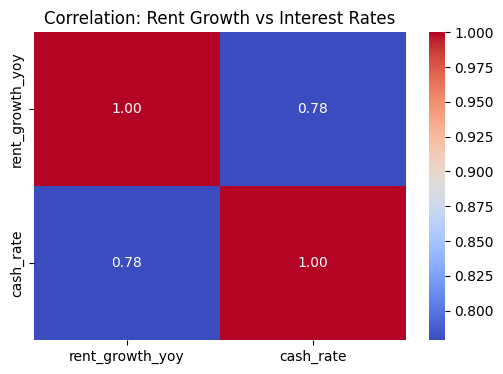

In [52]:
#correlation heatmap 
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(6,4))
sns.heatmap(combined[["rent_growth_yoy","cash_rate"]].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation: Rent Growth vs Interest Rates")
plt.show()

### Insight: Relationship between Rent Growth and Interest Rates 

The correlation analysis indicates strong positive relationship between annual rent growth and the RBA cash rate over the observed period, with correlation coefficient = 0.78 

This suggests that period of rising interest rates coincides with stronger rental growth. A plausible explanation is that higher interest rates reduce housing affordability for owner-occupiers, pushing demand into the rental market and placing upward pressure on rents. 

### Implication for the Investment Model 
- Rent growth assumptions should be treated as independent of the interest rate environment.
- Scenario analysis should account for correlated shocks bewteen financing costs and rental income. 
- This encourages the use of joint distributions rather than independent simulation when modelling future cash flows. 